### Обзор анекдотов, разделённых на категории: *пошлый*, *политический*, *бытовой*

In [7]:
import pandas as pd
import json
import nltk
import matplotlib.pyplot as plt

import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score

from cleaner import clean
from utils import read_csv_data

import toml

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
DATA_DIR = '../../data/'
JSON_FILE = 'dataset.json'

with open(DATA_DIR + JSON_FILE, 'r') as json_file:
    json_data = json.load(json_file)

In [6]:
json_data

{'count': 643,
 'items': {'anek_100038': {'text': '- Сынок, если ты съешь еще один кусок торта, ты лопнешь!- Дай мне торт и отойди подальше.',
   'другой': 1},
  'anek_100062': {'text': 'Не все, что жизнь может выкинуть, следует подбирать.',
   'другой': 1},
  'anek_100199': {'text': 'Я вчера ее так ждал, что если она не придет сегодня, то завтра я ее убью.',
   'бытовой': 1,
   'другой': 1},
  'anek_100213': {'text': 'В любовном треугольнике один угол - общего пользования.',
   'пошлый': 2},
  'anek_100612': {'text': 'Если у тебя прекрасная жена, обалденная любовница, крутая тачка, нет проблем с властями и налоговыми службами, а когда ты выходишь на улицу всегда светит солнце и прохожие тебе улыбаются - скажи нет наркотикам!',
   'другой': 1,
   'бытовой': 1},
  'anek_100883': {'text': 'Инженер советской закалки, чтобы решить неразрешимую задачу, прибегнет к водке и синей изоленте. А его британский коллега возьмет скотч и скотч.',
   'другой': 2,
   'бытовой': 1,
   'политический': 1}

In [8]:
table_data: dict = {
    'text': [],
    'home': [],
    'pervert': [],
    'polytical': [],
    'other': []
}

for i, item_ind in enumerate(json_data['items']):
    table_data['text'].append(json_data['items'][item_ind]['text'])
    table_data['home'].append(0)
    table_data['pervert'].append(0)
    table_data['polytical'].append(0)
    table_data['other'].append(0)

    for data in json_data['items'][item_ind]:
        if data == 'text':
            continue

        if data == 'пошлый':
            table_data['pervert'][i] = json_data['items'][item_ind][data]
        elif data == 'бытовой':
            table_data['home'][i] = json_data['items'][item_ind][data]
        elif data == 'политический':
            table_data['polytical'][i] = json_data['items'][item_ind][data]
        elif data == 'другой':
            table_data['other'][i] = json_data['items'][item_ind][data]

In [9]:
df = pd.DataFrame(table_data)

In [10]:
other_df = df[df['other'] > 0]
home_df = df[df['home'] > 0]
pervert_df = df[df['pervert'] > 0]
polytical_df = df[df['polytical'] > 0]

print(f'{len(other_df) = }')
print(f'{len(home_df) = }')
print(f'{len(pervert_df) = }')
print(f'{len(polytical_df) = }')

len(other_df) = 276
len(home_df) = 357
len(pervert_df) = 109
len(polytical_df) = 99


#### Частоты слов с каждой категории без предобработки

In [11]:
otherFD = nltk.FreqDist(word for text in df[df['other'] != 0]['text'] for word in text.lower().split())
homeFD = nltk.FreqDist(word for text in df[df['home'] != 0]['text'] for word in text.lower().split())
pervertFD = nltk.FreqDist(word for text in df[df['pervert'] != 0]['text'] for word in text.lower().split())
polyticalFD = nltk.FreqDist(word for text in df[df['polytical'] != 0]['text'] for word in text.lower().split())

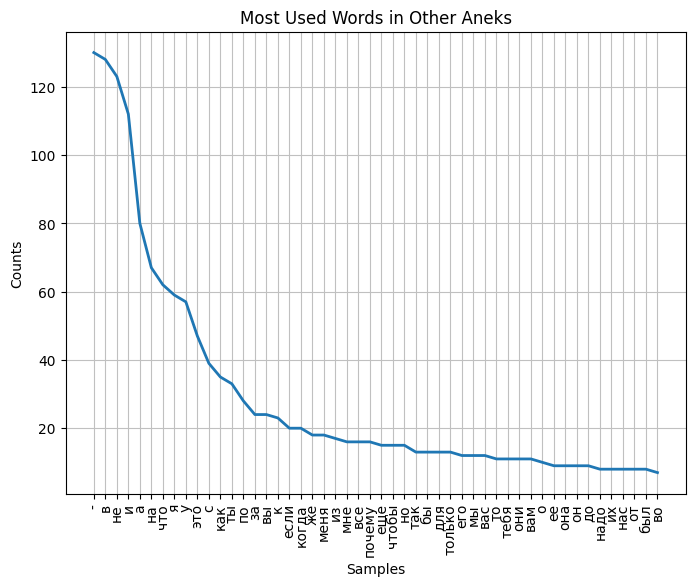

In [12]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Other Aneks")
otherFD.plot(50)
plt.show()

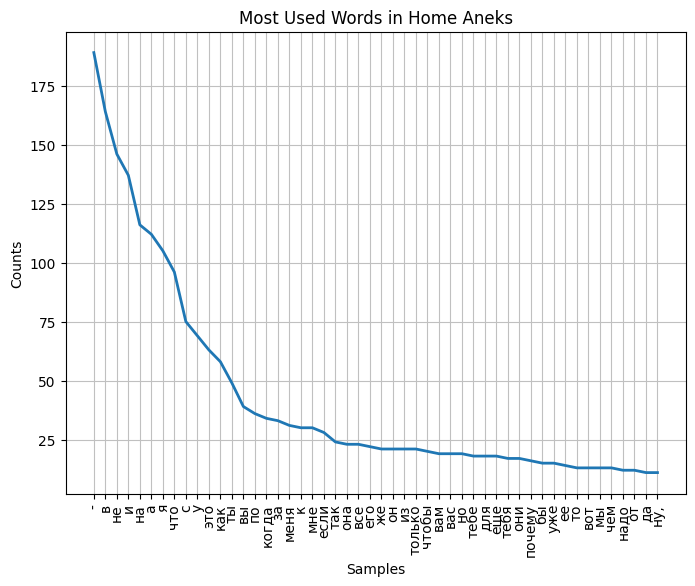

In [13]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Home Aneks")
homeFD.plot(50)
plt.show()

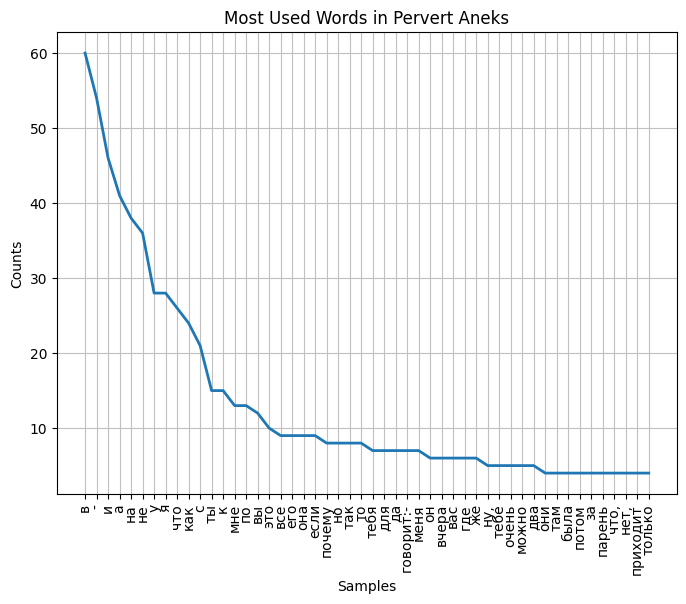

In [14]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Pervert Aneks")
pervertFD.plot(50)
plt.show()

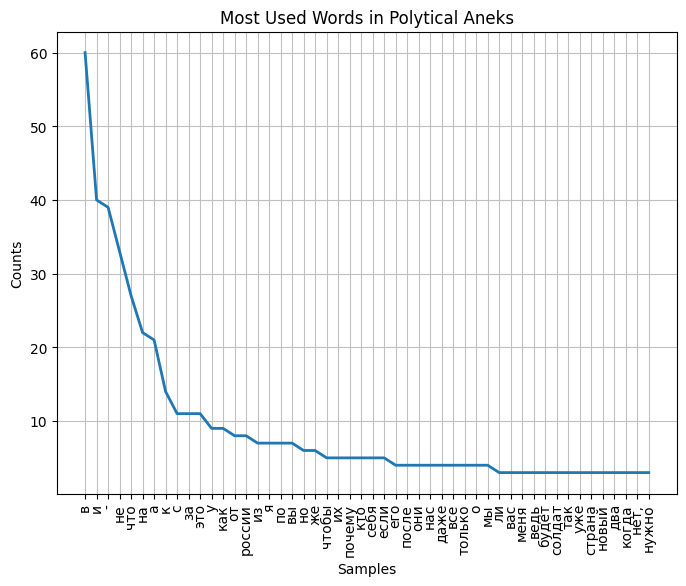

In [15]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Polytical Aneks")
polyticalFD.plot(50)
plt.show()

#### Частоты слов после очистки

In [16]:
df.head()

,text,home,pervert,polytical,other
0,"- Сынок, если ты съешь еще один кусок торта, т...",0,0,0,1
1,"Не все, что жизнь может выкинуть, следует подб...",0,0,0,1
2,"Я вчера ее так ждал, что если она не придет се...",1,0,0,1
3,В любовном треугольнике один угол - общего пол...,0,2,0,0
4,"Если у тебя прекрасная жена, обалденная любовн...",1,0,0,1


In [17]:
# df['text'].apply(clean)

In [15]:
# df['text'].apply(lambda x: len(x)).describe()

In [22]:
df['text'] = df['text'].apply(clean)

In [18]:
df['text']

0      - Сынок, если ты съешь еще один кусок торта, т...
1      Не все, что жизнь может выкинуть, следует подб...
2      Я вчера ее так ждал, что если она не придет се...
3      В любовном треугольнике один угол - общего пол...
4      Если у тебя прекрасная жена, обалденная любовн...
                             ...                        
638    - Ты где работаешь?- На спичечной фабрике.- И ...
639    У африканца, вернувшегося с обучения в России ...
640    Моя жена говорит мне:- Вот говорят, что мужчин...
641    Два голубя сидят, один другого по голове тюк-т...
642    Всегда беру энергетики с верхних полок - у них...
Name: text, Length: 643, dtype: object

In [24]:
df['text'].apply(lambda x: len(x)).describe()

count    643.000000
mean      77.430793
std       36.166792
min       11.000000
25%       52.000000
50%       71.000000
75%       95.000000
max      233.000000
Name: text, dtype: float64

In [25]:
otherFD = nltk.FreqDist(word for text in df[df['other'] != 0]['text'] for word in text.lower().split())
homeFD = nltk.FreqDist(word for text in df[df['home'] != 0]['text'] for word in text.lower().split())
pervertFD = nltk.FreqDist(word for text in df[df['pervert'] != 0]['text'] for word in text.lower().split())
polyticalFD = nltk.FreqDist(word for text in df[df['polytical'] != 0]['text'] for word in text.lower().split())

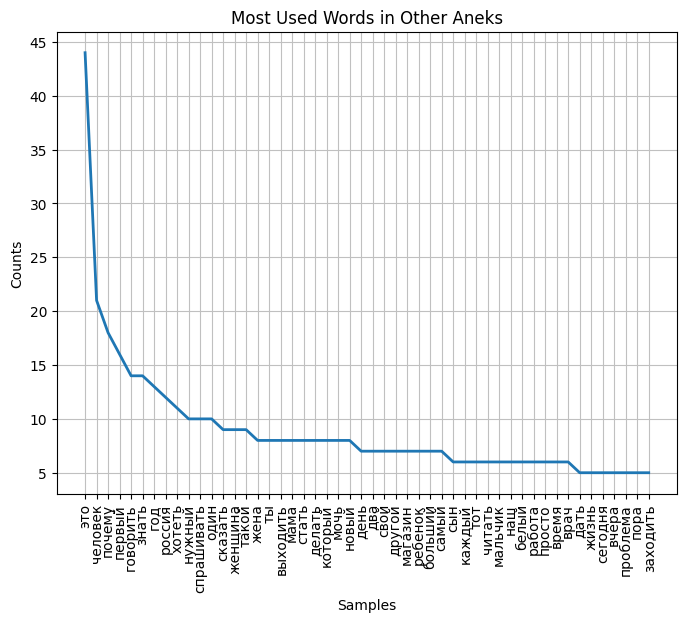

In [26]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Other Aneks")
otherFD.plot(50)
plt.show()

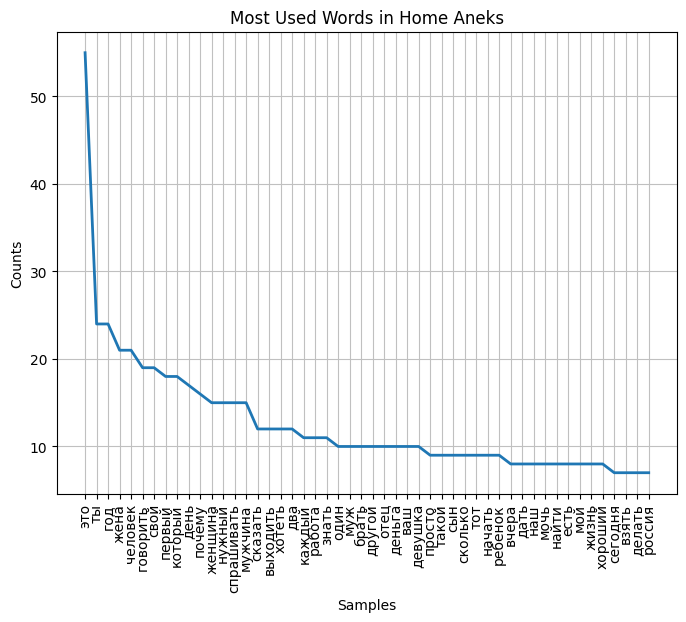

In [27]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Home Aneks")
homeFD.plot(50)
plt.show()

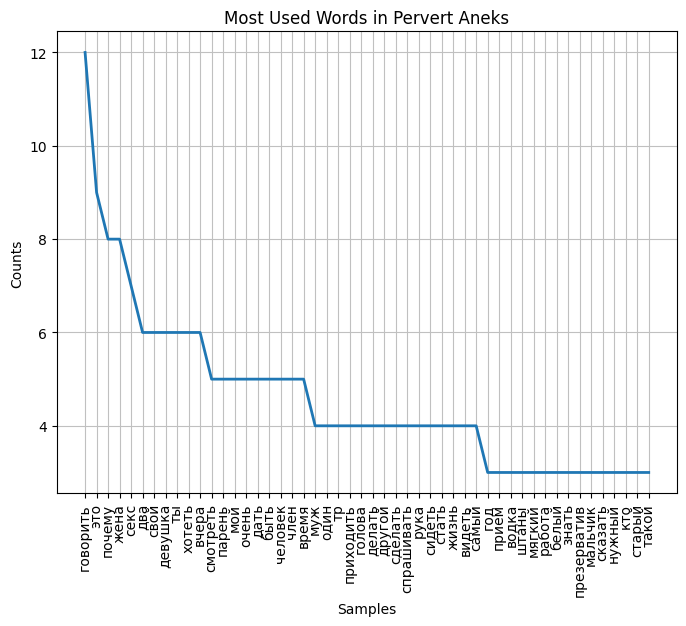

In [28]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Pervert Aneks")
pervertFD.plot(50)
plt.show()

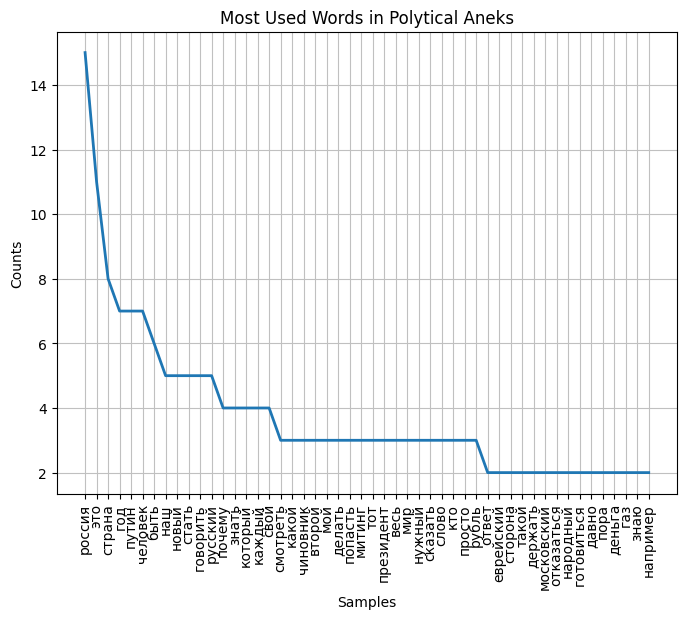

In [29]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Polytical Aneks")
polyticalFD.plot(50)
plt.show()

#### SVM

In [24]:
df.columns

Index(['text', 'home', 'pervert', 'polytical', 'other'], dtype='object')

In [25]:
(df['home'] + df['pervert'] + df['polytical']).max()

3

In [26]:
dfCombined = df.copy(deep=True)
dfCombined['labels'] = df['home'] + df['pervert'] + df['polytical']# + df['other']

In [27]:
dfCombined = dfCombined[dfCombined['labels'] == 1]

In [28]:
dfCombined

,text,home,pervert,polytical,other,labels
1,вчера завтра сегодня ждать убить прийти,1,0,0,1,1
2,пользование общий угол любовный треугольник,0,1,0,0,1
4,нравиться перестаньте утро выглядите делать ве...,1,0,0,0,1
5,помнить плафон энергосберегающий вчера лампочк...,1,0,0,0,1
6,продать фотография папка мамкин,1,0,0,0,1
...,...,...,...,...,...,...
443,убийство первый строго это просить мой судите,1,0,0,0,1
444,работа знакомиться женатый мужчина андрей зват...,1,0,0,0,1
447,университет жена жениться мужчина таки выше шк...,1,0,0,0,1
448,тюк голов другой взъерошиться молчать сидеть м...,0,1,0,0,1


In [29]:
HOME_LABEL = 1
PERVERT_LABEL = 2
POLYTICAL_LABEL = 3
# OTHER_LABEL = 4

dfCombined['labels'] = dfCombined['home'] * HOME_LABEL +\
                       dfCombined['pervert'] * PERVERT_LABEL +\
                       dfCombined['polytical'] * POLYTICAL_LABEL
                    #    dfCombined['other'] * OTHER_LABEL

dfCombined.drop(columns=['home', 'pervert', 'polytical', 'other'], inplace=True)

In [30]:
dfCombined

,text,labels
1,вчера завтра сегодня ждать убить прийти,1
2,пользование общий угол любовный треугольник,2
4,нравиться перестаньте утро выглядите делать ве...,1
5,помнить плафон энергосберегающий вчера лампочк...,1
6,продать фотография папка мамкин,1
...,...,...
443,убийство первый строго это просить мой судите,1
444,работа знакомиться женатый мужчина андрей зват...,1
447,университет жена жениться мужчина таки выше шк...,1
448,тюк голов другой взъерошиться молчать сидеть м...,2


In [31]:
X = dfCombined['text']
y = dfCombined['labels']

In [32]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1)

In [33]:
TfIdf = TfidfVectorizer(max_features=5000)
TfIdf.fit(X)
X_train_vectorized = TfIdf.transform(X_train)
X_test_vectorized = TfIdf.transform(X_test)

In [34]:
print(TfIdf.vocabulary_)

{'вчера': 239, 'завтра': 484, 'сегодня': 1491, 'ждать': 454, 'убить': 1766, 'прийти': 1310, 'пользование': 1216, 'общий': 972, 'угол': 1774, 'любовный': 732, 'треугольник': 1737, 'нравиться': 943, 'перестаньте': 1112, 'утро': 1823, 'выглядите': 247, 'делать': 362, 'вечерам': 158, 'помнить': 1221, 'плафон': 1140, 'энергосберегающий': 1977, 'лампочка': 698, 'хотеть': 1894, 'принести': 1318, 'покупать': 1199, 'домой': 407, 'гореть': 308, 'энергия': 1976, 'ввернуть': 135, 'беречь': 81, 'продать': 1344, 'фотография': 1862, 'папка': 1074, 'мамкин': 745, 'сложный': 1542, 'усложнить': 1809, 'простой': 1363, 'просто': 1362, 'женщина': 461, 'такой': 1691, 'ответ': 1026, 'один': 989, 'продаваться': 1341, 'головка': 297, 'полка': 1208, 'коробка': 654, 'еврейский': 431, 'посмотреть': 1250, 'держать': 368, 'верхний': 151, 'заваляться': 477, 'спичка': 1606, 'казаться': 595, 'сторона': 1642, 'продавец': 1342, 'хотеться': 1895, 'сон': 1584, 'уставать': 1817, 'пора': 1239, 'день': 364, 'спать': 1601, 'с

In [35]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='poly', degree=3, gamma='auto')
SVM.fit(X_train_vectorized, y_train)

predictions_SVM = SVM.predict(X_test_vectorized)
print("SVM (O-v-O) F1 Score -> ", f1_score(predictions_SVM, y_test, average='micro') * 100)

SVM (O-v-O) F1 Score ->  61.29032258064516


In [36]:
lin_clf = svm.LinearSVC(dual="auto")
lin_clf.fit(X_train_vectorized, y_train)

predictions_SVM = lin_clf.predict(X_test_vectorized)
print("SVM (O-v-R) F1 Score -> ", f1_score(predictions_SVM, y_test, average='micro') * 100)

SVM (O-v-R) F1 Score ->  61.29032258064516


In [37]:
linear_param_grid = {
    'dual': [False, True],
    'C': [0.1, 0.5, 1, 5, 10, 100]
}

grid = GridSearchCV(svm.LinearSVC(), linear_param_grid , scoring='f1_micro', refit=True , verbose=3)
grid.fit(X_train_vectorized, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .................C=0.1, dual=False;, score=0.709 total time=   0.0s
[CV 2/5] END .................C=0.1, dual=False;, score=0.709 total time=   0.0s
[CV 3/5] END .................C=0.1, dual=False;, score=0.709 total time=   0.0s
[CV 4/5] END .................C=0.1, dual=False;, score=0.709 total time=   0.0s
[CV 5/5] END .................C=0.1, dual=False;, score=0.704 total time=   0.0s
[CV 1/5] END ..................C=0.1, dual=True;, score=0.709 total time=   0.0s
[CV 2/5] END ..................C=0.1, dual=True;, score=0.709 total time=   0.0s
[CV 3/5] END ..................C=0.1, dual=True;, score=0.709 total time=   0.0s
[CV 4/5] END ..................C=0.1, dual=True;, score=0.709 total time=   0.0s
[CV 5/5] END ..................C=0.1, dual=True;, score=0.704 total time=   0.0s
[CV 1/5] END .................C=0.5, dual=False;, score=0.709 total time=   0.0s
[CV 2/5] END .................C=0.5, dual=False;

GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 100], 'dual': [False, True]},
             scoring='f1_micro', verbose=3)

In [38]:
grid.best_score_

0.7116498316498316

In [39]:
grid.best_estimator_

LinearSVC(C=5, dual=False)

In [40]:
svc_param_grid = {
    'kernel': ('linear', 'rbf', 'poly'),
    'C': [0.1, 0.5, 1, 5, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001], 
    'degree' : [1, 2, 3, 4, 5, 6]
}

grid = GridSearchCV(svm.SVC() , svc_param_grid, scoring='f1_micro', refit=True , verbose=3)
grid.fit(X_train_vectorized, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV 1/5] END C=0.1, degree=1, gamma=1, kernel=linear;, score=0.709 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=1, kernel=linear;, score=0.709 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=1, kernel=linear;, score=0.709 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=1, kernel=linear;, score=0.709 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=1, kernel=linear;, score=0.704 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=1, kernel=rbf;, score=0.709 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=1, kernel=rbf;, score=0.709 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=1, kernel=rbf;, score=0.709 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=1, kernel=rbf;, score=0.709 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=1, kernel=rbf;, score=0.704 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=1, kernel=poly;, score=0.709 total time=   0.0s
[CV 2/5

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 100],
                         'degree': [1, 2, 3, 4, 5, 6],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ('linear', 'rbf', 'poly')},
             scoring='f1_micro', verbose=3)

In [41]:
grid.best_score_

0.7116498316498316

In [42]:
from gensim.models import Word2Vec

w2v = Word2Vec(sentences=X, vector_size=150, window=5, min_count=1, workers=4)

1

In [44]:
Xw2v = pd.Series(X)

In [51]:
X_test_vectorized[0]

<1x1993 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

### Statistics

In [9]:
df = read_csv_data('../../data/dataset.csv')

In [10]:
df['class'] = df['class'].astype('category')
df = df.drop(df[df['class'] == 'other'].index)

encoder = LabelEncoder()
encoder.fit(df['class'])

df['class'] = encoder.transform(df['class'])

In [11]:
df

,text,class
2,"Я вчера ее так ждал, что если она не придет се...",0
4,В любовном треугольнике один угол - общего пол...,1
6,"Если у тебя прекрасная жена, обалденная любовн...",0
8,"Если по утрам вам не нравится, как вы выглядит...",0
9,- Я у вас вчера лампочку энергосберегающую пок...,0
...,...,...
755,"Если испугать Анфису Чехову, то она спрячет го...",1
759,"У африканца, вернувшегося с обучения в России ...",0
760,"Моя жена говорит мне:- Вот говорят, что мужчин...",0
761,"Два голубя сидят, один другого по голове тюк-т...",1


Number of texts

In [12]:
len(df)

530

Number of tokens

In [13]:
freqDist = nltk.FreqDist(word for text in df['text'] for word in text.lower().split())

In [14]:
freqDist.N()

9685

Train/Test

In [15]:
with open('bert_config.toml', 'r') as config_file:
    config = toml.load(config_file)

MODEL_NAME: str = config['model']['name']
TEST_SIZE: float = config['dataset']['test_size']
EVAL_SIZE: float = config['dataset']['eval_size']
SEED: int = config['random_seed']

In [16]:
train_split, test_split = train_test_split(df, test_size=TEST_SIZE, random_state=SEED)
train_split, eval_split = train_test_split(train_split, test_size=EVAL_SIZE, random_state=SEED)

Save Train/Test/Valid subsets

In [36]:
train_split.to_csv('train.csv', index=False)
test_split.to_csv('test.csv', index=False)
eval_split.to_csv('valid.csv', index=False)

In [24]:
freqTrainDist = nltk.FreqDist(word for text in train_split['text'] for word in text.lower().split())
freqTestDist = nltk.FreqDist(word for text in test_split['text'] for word in text.lower().split())
freqEvalDist = nltk.FreqDist(word for text in eval_split['text'] for word in text.lower().split())

In [25]:
from pprint import pprint

pprint([freqTrainDist.N(), freqTestDist.N(), freqEvalDist.N()])
pprint([freqTrainDist.B(), freqTestDist.B(), freqEvalDist.B()])
pprint([len(train_split), len(test_split), len(eval_split)])

[6866, 2056, 763]
[3624, 1303, 539]
[381, 106, 43]


In [26]:
df['text'].apply(lambda x: len(x)).describe()

count    530.000000
mean     115.343396
std       50.910565
min       31.000000
25%       78.000000
50%      104.000000
75%      144.750000
max      310.000000
Name: text, dtype: float64

In [27]:
from collections import Counter

counts = Counter(word for text in train_split['text'] for word in text.lower().split())

In [28]:
len(counts)

3624

In [29]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, truncation=True, do_lower_case=True)

In [30]:
tokenizer.vocab_size

83828

In [31]:
def count_tokens(subset):
    texts = subset['text'].to_numpy()
    num_of_tokens = 0

    for i in range(len(texts)):
        inputs = tokenizer.encode_plus(
            texts[i],
            None,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        num_of_tokens += len(inputs['input_ids'])
    
    return num_of_tokens

In [32]:
count_tokens(train_split)

c:\Users\Vill\anaconda3\envs\ods\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


11904

In [33]:
count_tokens(test_split)

3580

In [34]:
count_tokens(eval_split)

1336